In [1]:
import pandas as pd 
import numpy as np 
import csv  
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [49]:
crashes_data = pd.read_csv('data/Traffic_Crashes_-_Crashes.csv')
crashes_data.info()

/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541142 entries, 0 to 541141
Data columns (total 49 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                541142 non-null  object 
 1   RD_NO                          536550 non-null  object 
 2   CRASH_DATE_EST_I               41029 non-null   object 
 3   CRASH_DATE                     541142 non-null  object 
 4   POSTED_SPEED_LIMIT             541142 non-null  int64  
 5   TRAFFIC_CONTROL_DEVICE         541142 non-null  object 
 6   DEVICE_CONDITION               541142 non-null  object 
 7   WEATHER_CONDITION              541142 non-null  object 
 8   LIGHTING_CONDITION             541142 non-null  object 
 9   FIRST_CRASH_TYPE               541142 non-null  object 
 10  TRAFFICWAY_TYPE                541142 non-null  object 
 11  LANE_CNT                       198968 non-null  float64
 12  ALIGNMENT                     

In [50]:
crashes_data.drop(crashes_data.columns[np.r_[1,2,5,10:13,15,17:20,21,24:35,36:43,48]], axis=1, inplace=True)
crashes_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541142 entries, 0 to 541141
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   CRASH_RECORD_ID          541142 non-null  object 
 1   CRASH_DATE               541142 non-null  object 
 2   POSTED_SPEED_LIMIT       541142 non-null  int64  
 3   DEVICE_CONDITION         541142 non-null  object 
 4   WEATHER_CONDITION        541142 non-null  object 
 5   LIGHTING_CONDITION       541142 non-null  object 
 6   FIRST_CRASH_TYPE         541142 non-null  object 
 7   ROADWAY_SURFACE_COND     541142 non-null  object 
 8   ROAD_DEFECT              541142 non-null  object 
 9   CRASH_TYPE               541142 non-null  object 
 10  DAMAGE                   541142 non-null  object 
 11  PRIM_CONTRIBUTORY_CAUSE  541142 non-null  object 
 12  SEC_CONTRIBUTORY_CAUSE   541142 non-null  object 
 13  MOST_SEVERE_INJURY       540019 non-null  object 
 14  CRAS

Exploratory Data Analysis
Step 1: Import and read data
Step 2: Check datatypes
Step 3: Check duplicates
Step 4: Check nulls/missing values
Step 5: Check outliers

In [51]:
people_data = pd.read_csv('data/Traffic_Crashes_-_People.csv')
people_data.info()

/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (12,13,20,21,22,23,24,25,26,27,29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1195089 entries, 0 to 1195088
Data columns (total 30 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   PERSON_ID              1195089 non-null  object 
 1   PERSON_TYPE            1195089 non-null  object 
 2   CRASH_RECORD_ID        1195089 non-null  object 
 3   RD_NO                  1184791 non-null  object 
 4   VEHICLE_ID             1171503 non-null  float64
 5   CRASH_DATE             1195089 non-null  object 
 6   SEAT_NO                244372 non-null   float64
 7   CITY                   879272 non-null   object 
 8   STATE                  889722 non-null   object 
 9   ZIPCODE                802767 non-null   object 
 10  SEX                    1177027 non-null  object 
 11  AGE                    851997 non-null   float64
 12  DRIVERS_LICENSE_STATE  705170 non-null   object 
 13  DRIVERS_LICENSE_CLASS  607731 non-null   object 
 14  SAFETY_EQUIPMENT  

In [52]:
people_data = pd.read_csv('data/Traffic_Crashes_-_People.csv')
people_data.drop(people_data.columns[np.r_[3:10,11,12,13,17:30]], axis=1, inplace=True)
people_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1195089 entries, 0 to 1195088
Data columns (total 7 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   PERSON_ID         1195089 non-null  object
 1   PERSON_TYPE       1195089 non-null  object
 2   CRASH_RECORD_ID   1195089 non-null  object
 3   SEX               1177027 non-null  object
 4   SAFETY_EQUIPMENT  1191601 non-null  object
 5   AIRBAG_DEPLOYED   1172498 non-null  object
 6   EJECTION          1180555 non-null  object
dtypes: object(7)
memory usage: 63.8+ MB


In [53]:
vehicles_data = pd.read_csv('data/Traffic_Crashes_-_Vehicles.csv')
vehicles_data.info()

/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (19,21,40,41,42,44,48,49,50,53,55,58,59,61,71) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1107267 entries, 0 to 1107266
Data columns (total 72 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   CRASH_UNIT_ID             1107267 non-null  int64  
 1   CRASH_RECORD_ID           1107267 non-null  object 
 2   RD_NO                     1097786 non-null  object 
 3   CRASH_DATE                1107267 non-null  object 
 4   UNIT_NO                   1107267 non-null  int64  
 5   UNIT_TYPE                 1105670 non-null  object 
 6   NUM_PASSENGERS            165920 non-null   float64
 7   VEHICLE_ID                1081934 non-null  float64
 8   CMRC_VEH_I                20475 non-null    object 
 9   MAKE                      1081929 non-null  object 
 10  MODEL                     1081786 non-null  object 
 11  LIC_PLATE_STATE           987487 non-null   object 
 12  VEHICLE_YEAR              905696 non-null   float64
 13  VEHICLE_DEFECT            1

In [54]:
vehicles_data.drop(vehicles_data.columns[np.r_[0,2:13,16,18:38,39:72]], axis=1, inplace=True)
vehicles_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1107267 entries, 0 to 1107266
Data columns (total 6 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   CRASH_RECORD_ID      1107267 non-null  object
 1   VEHICLE_DEFECT       1081934 non-null  object
 2   VEHICLE_TYPE         1081934 non-null  object
 3   VEHICLE_USE          1081934 non-null  object
 4   MANEUVER             1081934 non-null  object
 5   FIRST_CONTACT_POINT  1073691 non-null  object
dtypes: object(6)
memory usage: 50.7+ MB


In [55]:
people_crashes_data = crashes_data.merge(people_data, on='CRASH_RECORD_ID')
df = people_crashes_data.merge(vehicles_data, on='CRASH_RECORD_ID')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2528859 entries, 0 to 2528858
Data columns (total 30 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   CRASH_RECORD_ID          object 
 1   CRASH_DATE               object 
 2   POSTED_SPEED_LIMIT       int64  
 3   DEVICE_CONDITION         object 
 4   WEATHER_CONDITION        object 
 5   LIGHTING_CONDITION       object 
 6   FIRST_CRASH_TYPE         object 
 7   ROADWAY_SURFACE_COND     object 
 8   ROAD_DEFECT              object 
 9   CRASH_TYPE               object 
 10  DAMAGE                   object 
 11  PRIM_CONTRIBUTORY_CAUSE  object 
 12  SEC_CONTRIBUTORY_CAUSE   object 
 13  MOST_SEVERE_INJURY       object 
 14  CRASH_HOUR               int64  
 15  CRASH_DAY_OF_WEEK        int64  
 16  CRASH_MONTH              int64  
 17  LATITUDE                 float64
 18  LONGITUDE                float64
 19  PERSON_ID                object 
 20  PERSON_TYPE              object 
 21  SEX     

In [56]:
df['MOST_SEVERE_INJURY'] = df['MOST_SEVERE_INJURY'].map({'NO INDICATION OF INJURY': 'mild', 
                                                                         'REPORTED, NOT EVIDENT': 'mild',
                                                                         'NONINCAPACITATING INJURY': 'medium',
                                                                         'INCAPACITATING INJURY': 'severe',
                                                                         'FATAL': 'severe'})
df['MOST_SEVERE_INJURY']

0          mild
1          mild
2          mild
3          mild
4          mild
           ... 
2528854    mild
2528855    mild
2528856    mild
2528857    mild
2528858    mild
Name: MOST_SEVERE_INJURY, Length: 2528859, dtype: object

In [57]:
df.duplicated().sum()

73592

In [58]:
df.drop_duplicates(inplace=True)

In [59]:
df['LATITUDE'].fillna(df['LATITUDE'].mean(), inplace=True )
df['LONGITUDE'].fillna(df['LONGITUDE'].mean(), inplace=True )

In [60]:
df.dropna(subset=['MOST_SEVERE_INJURY'], inplace=True)

In [61]:
df['SAFETY_EQUIPMENT'].value_counts()

SAFETY BELT USED                              1216265
USAGE UNKNOWN                                 1094886
NONE PRESENT                                    77017
CHILD RESTRAINT USED                            16187
SAFETY BELT NOT USED                            14150
HELMET NOT USED                                  9452
CHILD RESTRAINT - FORWARD FACING                 4650
BICYCLE HELMET (PEDACYCLIST INVOLVED ONLY)       3313
HELMET USED                                      2663
CHILD RESTRAINT - TYPE UNKNOWN                   2369
CHILD RESTRAINT - REAR FACING                    2257
DOT COMPLIANT MOTORCYCLE HELMET                  1277
BOOSTER SEAT                                     1225
CHILD RESTRAINT NOT USED                         1215
NOT DOT COMPLIANT MOTORCYCLE HELMET               258
SHOULD/LAP BELT USED IMPROPERLY                   246
WHEELCHAIR                                        229
CHILD RESTRAINT USED IMPROPERLY                   191
STRETCHER                   

In [62]:
df['SEX'].fillna('X', inplace=True)

df['SEX'] = df['SEX'].map({'M': 'M', 
                           'F': 'F',
                           'X': 'Unknown'})
df['SEX'].value_counts()

M          1277919
F           928875
Unknown     248453
Name: SEX, dtype: int64

In [63]:
df['SAFETY_EQUIPMENT'].fillna('USAGE UNKNOWN', inplace=True)
df['AIRBAG_DEPLOYED'].fillna('DEPLOYMENT UNKNOWN', inplace=True)
df['EJECTION'].fillna('UNKNOWN', inplace=True)
df['VEHICLE_DEFECT'].fillna('UNKNOWN', inplace=True)
df['VEHICLE_TYPE'].fillna('UNKNOWN/NA', inplace=True)
df['VEHICLE_USE'].fillna('UNKNOWN/NA', inplace=True)
df['MANEUVER'].fillna('UNKNOWN/NA', inplace=True)
df['FIRST_CONTACT_POINT'].fillna('UNKNOWN', inplace=True)
df


,CRASH_RECORD_ID,CRASH_DATE,POSTED_SPEED_LIMIT,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,ROADWAY_SURFACE_COND,ROAD_DEFECT,CRASH_TYPE,...,PERSON_TYPE,SEX,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,MANEUVER,FIRST_CONTACT_POINT
0,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,07/10/2019 05:56:00 PM,35,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,DRIVER,M,USAGE UNKNOWN,NOT APPLICABLE,NONE,UNKNOWN,PASSENGER,PERSONAL,BACKING,REAR
1,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,07/10/2019 05:56:00 PM,35,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,DRIVER,M,USAGE UNKNOWN,NOT APPLICABLE,NONE,UNKNOWN,PASSENGER,PERSONAL,TURNING RIGHT,FRONT
2,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,07/10/2019 05:56:00 PM,35,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,DRIVER,M,USAGE UNKNOWN,NOT APPLICABLE,NONE,UNKNOWN,PASSENGER,PERSONAL,BACKING,REAR
3,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,07/10/2019 05:56:00 PM,35,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,DRIVER,M,USAGE UNKNOWN,NOT APPLICABLE,NONE,UNKNOWN,PASSENGER,PERSONAL,TURNING RIGHT,FRONT
4,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,07/10/2019 05:56:00 PM,35,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,PASSENGER,M,USAGE UNKNOWN,NOT APPLICABLE,NONE,UNKNOWN,PASSENGER,PERSONAL,BACKING,REAR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2528853,d51aae396db49981c7ee26ceb54dfcab3c4b06d0cc5d7d...,07/12/2021 10:00:00 AM,30,NO CONTROLS,CLEAR,DAYLIGHT,REAR TO SIDE,DRY,NO DEFECTS,INJURY AND / OR TOW DUE TO CRASH,...,DRIVER,M,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,NONE,NONE,PASSENGER,PERSONAL,STRAIGHT AHEAD,FRONT-LEFT
2528854,d51aae396db49981c7ee26ceb54dfcab3c4b06d0cc5d7d...,07/12/2021 10:00:00 AM,30,NO CONTROLS,CLEAR,DAYLIGHT,REAR TO SIDE,DRY,NO DEFECTS,INJURY AND / OR TOW DUE TO CRASH,...,DRIVER,F,SAFETY BELT USED,DID NOT DEPLOY,NONE,UNKNOWN,PASSENGER,PERSONAL,BACKING,REAR-LEFT
2528855,d51aae396db49981c7ee26ceb54dfcab3c4b06d0cc5d7d...,07/12/2021 10:00:00 AM,30,NO CONTROLS,CLEAR,DAYLIGHT,REAR TO SIDE,DRY,NO DEFECTS,INJURY AND / OR TOW DUE TO CRASH,...,DRIVER,F,SAFETY BELT USED,DID NOT DEPLOY,NONE,NONE,PASSENGER,PERSONAL,STRAIGHT AHEAD,FRONT-LEFT
2528856,c83fa5092963bda54b781bf8cfdd840b5106004afbdd34...,07/13/2021 10:30:00 PM,30,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,DRY,NO DEFECTS,INJURY AND / OR TOW DUE TO CRASH,...,DRIVER,F,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN/NA,UNKNOWN/NA,UNKNOWN/NA,TOTAL (ALL AREAS)


In [64]:
df.isnull().sum()

CRASH_RECORD_ID            0
CRASH_DATE                 0
POSTED_SPEED_LIMIT         0
DEVICE_CONDITION           0
WEATHER_CONDITION          0
LIGHTING_CONDITION         0
FIRST_CRASH_TYPE           0
ROADWAY_SURFACE_COND       0
ROAD_DEFECT                0
CRASH_TYPE                 0
DAMAGE                     0
PRIM_CONTRIBUTORY_CAUSE    0
SEC_CONTRIBUTORY_CAUSE     0
MOST_SEVERE_INJURY         0
CRASH_HOUR                 0
CRASH_DAY_OF_WEEK          0
CRASH_MONTH                0
LATITUDE                   0
LONGITUDE                  0
PERSON_ID                  0
PERSON_TYPE                0
SEX                        0
SAFETY_EQUIPMENT           0
AIRBAG_DEPLOYED            0
EJECTION                   0
VEHICLE_DEFECT             0
VEHICLE_TYPE               0
VEHICLE_USE                0
MANEUVER                   0
FIRST_CONTACT_POINT        0
dtype: int64

In [65]:
import datetime as datetime
df['CRASH_DATE'] = df['CRASH_DATE'].map(lambda x: datetime.datetime.strptime(x[0:10], "%m/%d/%Y"))
df['CRASH_DATE']

0         2019-07-10
1         2019-07-10
2         2019-07-10
3         2019-07-10
4         2019-07-10
             ...    
2528853   2021-07-12
2528854   2021-07-12
2528855   2021-07-12
2528856   2021-07-13
2528857   2021-07-13
Name: CRASH_DATE, Length: 2455247, dtype: datetime64[ns]

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2455247 entries, 0 to 2528857
Data columns (total 30 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   CRASH_RECORD_ID          object        
 1   CRASH_DATE               datetime64[ns]
 2   POSTED_SPEED_LIMIT       int64         
 3   DEVICE_CONDITION         object        
 4   WEATHER_CONDITION        object        
 5   LIGHTING_CONDITION       object        
 6   FIRST_CRASH_TYPE         object        
 7   ROADWAY_SURFACE_COND     object        
 8   ROAD_DEFECT              object        
 9   CRASH_TYPE               object        
 10  DAMAGE                   object        
 11  PRIM_CONTRIBUTORY_CAUSE  object        
 12  SEC_CONTRIBUTORY_CAUSE   object        
 13  MOST_SEVERE_INJURY       object        
 14  CRASH_HOUR               int64         
 15  CRASH_DAY_OF_WEEK        int64         
 16  CRASH_MONTH              int64         
 17  LATITUDE                 fl

In [68]:
df["CRASH_DATE"].isin(pd.date_range("2019-01-01", "2020-01-01"))
# df['CRASH_DATE']

0           True
1           True
2           True
3           True
4           True
           ...  
2528853    False
2528854    False
2528855    False
2528856    False
2528857    False
Name: CRASH_DATE, Length: 2455247, dtype: bool

In [72]:
df= df[df["CRASH_DATE"].isin(pd.date_range("2019-01-01", "2020-01-01"))]

df

,CRASH_RECORD_ID,CRASH_DATE,POSTED_SPEED_LIMIT,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,ROADWAY_SURFACE_COND,ROAD_DEFECT,CRASH_TYPE,...,PERSON_TYPE,SEX,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,MANEUVER,FIRST_CONTACT_POINT
0,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,2019-07-10,35,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,DRIVER,M,USAGE UNKNOWN,NOT APPLICABLE,NONE,UNKNOWN,PASSENGER,PERSONAL,BACKING,REAR
1,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,2019-07-10,35,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,DRIVER,M,USAGE UNKNOWN,NOT APPLICABLE,NONE,UNKNOWN,PASSENGER,PERSONAL,TURNING RIGHT,FRONT
2,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,2019-07-10,35,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,DRIVER,M,USAGE UNKNOWN,NOT APPLICABLE,NONE,UNKNOWN,PASSENGER,PERSONAL,BACKING,REAR
3,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,2019-07-10,35,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,DRIVER,M,USAGE UNKNOWN,NOT APPLICABLE,NONE,UNKNOWN,PASSENGER,PERSONAL,TURNING RIGHT,FRONT
4,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,2019-07-10,35,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,PASSENGER,M,USAGE UNKNOWN,NOT APPLICABLE,NONE,UNKNOWN,PASSENGER,PERSONAL,BACKING,REAR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2528207,ffff27f5ef6d4465bf2e6da46c1d07ac6f017c6ca1f477...,2019-06-19,25,FUNCTIONING PROPERLY,RAIN,"DARKNESS, LIGHTED ROAD",TURNING,WET,NO DEFECTS,NO INJURY / DRIVE AWAY,...,DRIVER,M,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,NONE,UNKNOWN,PICKUP,UNKNOWN/NA,TURNING RIGHT,REAR-LEFT
2528208,ffff27f5ef6d4465bf2e6da46c1d07ac6f017c6ca1f477...,2019-06-19,25,FUNCTIONING PROPERLY,RAIN,"DARKNESS, LIGHTED ROAD",TURNING,WET,NO DEFECTS,NO INJURY / DRIVE AWAY,...,DRIVER,M,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,NONE,UNKNOWN,UNKNOWN/NA,PERSONAL,TURNING LEFT,SIDE-RIGHT
2528209,ffff27f5ef6d4465bf2e6da46c1d07ac6f017c6ca1f477...,2019-06-19,25,FUNCTIONING PROPERLY,RAIN,"DARKNESS, LIGHTED ROAD",TURNING,WET,NO DEFECTS,NO INJURY / DRIVE AWAY,...,DRIVER,F,SAFETY BELT USED,DID NOT DEPLOY,NONE,UNKNOWN,PICKUP,UNKNOWN/NA,TURNING RIGHT,REAR-LEFT
2528210,ffff27f5ef6d4465bf2e6da46c1d07ac6f017c6ca1f477...,2019-06-19,25,FUNCTIONING PROPERLY,RAIN,"DARKNESS, LIGHTED ROAD",TURNING,WET,NO DEFECTS,NO INJURY / DRIVE AWAY,...,DRIVER,F,SAFETY BELT USED,DID NOT DEPLOY,NONE,UNKNOWN,UNKNOWN/NA,PERSONAL,TURNING LEFT,SIDE-RIGHT


In [73]:

import geopandas as gpd
from shapely.geometry import Point, Polygon
%matplotlib inline
import descartes

<AxesSubplot:>

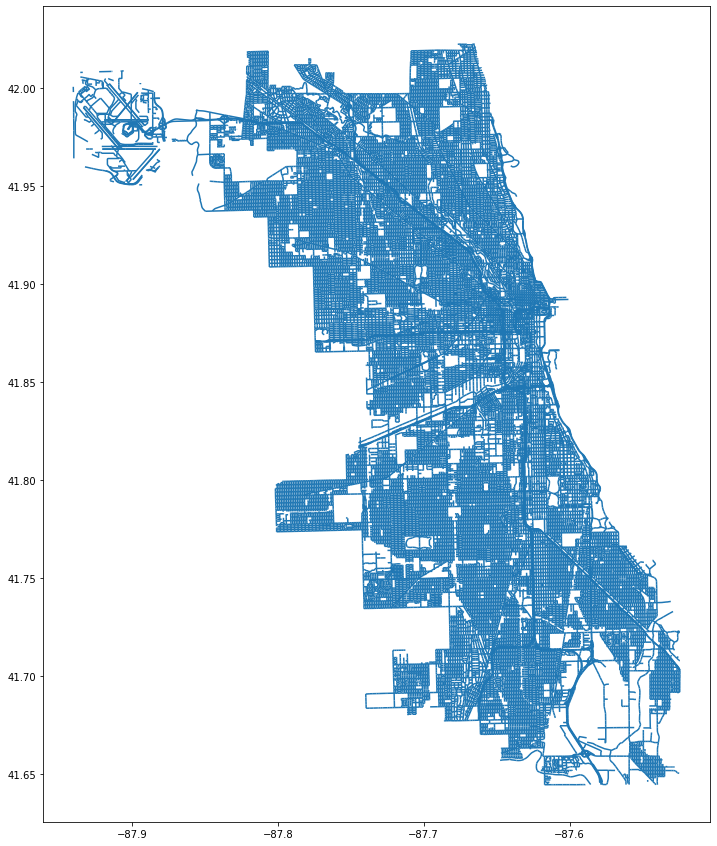

In [74]:
street_map = gpd.read_file('data/street_center_lines/geo_export_5b756109-9119-4fba-8896-3b624808d48f.shp')
fig,ax = plt.subplots(figsize = (15,15))
street_map.plot(ax=ax)


In [79]:
crs = {'init': 'epsg:4326'}
geo = [Point(xy) for xy in zip( df["LONGITUDE"], df["LATITUDE"])]
geo[:3]

In [76]:
geo_df = gpd.GeoDataFrame(df, crs=crs,  geometry=geo )
geo_df = geo_df[geo_df['LONGITUDE'] != 0.0]
geo_df

/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,CRASH_RECORD_ID,CRASH_DATE,POSTED_SPEED_LIMIT,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,ROADWAY_SURFACE_COND,ROAD_DEFECT,CRASH_TYPE,...,SEX,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,MANEUVER,FIRST_CONTACT_POINT,geometry
0,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,2019-07-10,35,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,M,USAGE UNKNOWN,NOT APPLICABLE,NONE,UNKNOWN,PASSENGER,PERSONAL,BACKING,REAR,POINT (-87.77329 41.91966)
1,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,2019-07-10,35,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,M,USAGE UNKNOWN,NOT APPLICABLE,NONE,UNKNOWN,PASSENGER,PERSONAL,TURNING RIGHT,FRONT,POINT (-87.77329 41.91966)
2,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,2019-07-10,35,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,M,USAGE UNKNOWN,NOT APPLICABLE,NONE,UNKNOWN,PASSENGER,PERSONAL,BACKING,REAR,POINT (-87.77329 41.91966)
3,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,2019-07-10,35,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,M,USAGE UNKNOWN,NOT APPLICABLE,NONE,UNKNOWN,PASSENGER,PERSONAL,TURNING RIGHT,FRONT,POINT (-87.77329 41.91966)
4,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,2019-07-10,35,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,M,USAGE UNKNOWN,NOT APPLICABLE,NONE,UNKNOWN,PASSENGER,PERSONAL,BACKING,REAR,POINT (-87.77329 41.91966)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2528207,ffff27f5ef6d4465bf2e6da46c1d07ac6f017c6ca1f477...,2019-06-19,25,FUNCTIONING PROPERLY,RAIN,"DARKNESS, LIGHTED ROAD",TURNING,WET,NO DEFECTS,NO INJURY / DRIVE AWAY,...,M,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,NONE,UNKNOWN,PICKUP,UNKNOWN/NA,TURNING RIGHT,REAR-LEFT,POINT (-87.70523 41.85817)
2528208,ffff27f5ef6d4465bf2e6da46c1d07ac6f017c6ca1f477...,2019-06-19,25,FUNCTIONING PROPERLY,RAIN,"DARKNESS, LIGHTED ROAD",TURNING,WET,NO DEFECTS,NO INJURY / DRIVE AWAY,...,M,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,NONE,UNKNOWN,UNKNOWN/NA,PERSONAL,TURNING LEFT,SIDE-RIGHT,POINT (-87.70523 41.85817)
2528209,ffff27f5ef6d4465bf2e6da46c1d07ac6f017c6ca1f477...,2019-06-19,25,FUNCTIONING PROPERLY,RAIN,"DARKNESS, LIGHTED ROAD",TURNING,WET,NO DEFECTS,NO INJURY / DRIVE AWAY,...,F,SAFETY BELT USED,DID NOT DEPLOY,NONE,UNKNOWN,PICKUP,UNKNOWN/NA,TURNING RIGHT,REAR-LEFT,POINT (-87.70523 41.85817)
2528210,ffff27f5ef6d4465bf2e6da46c1d07ac6f017c6ca1f477...,2019-06-19,25,FUNCTIONING PROPERLY,RAIN,"DARKNESS, LIGHTED ROAD",TURNING,WET,NO DEFECTS,NO INJURY / DRIVE AWAY,...,F,SAFETY BELT USED,DID NOT DEPLOY,NONE,UNKNOWN,UNKNOWN/NA,PERSONAL,TURNING LEFT,SIDE-RIGHT,POINT (-87.70523 41.85817)


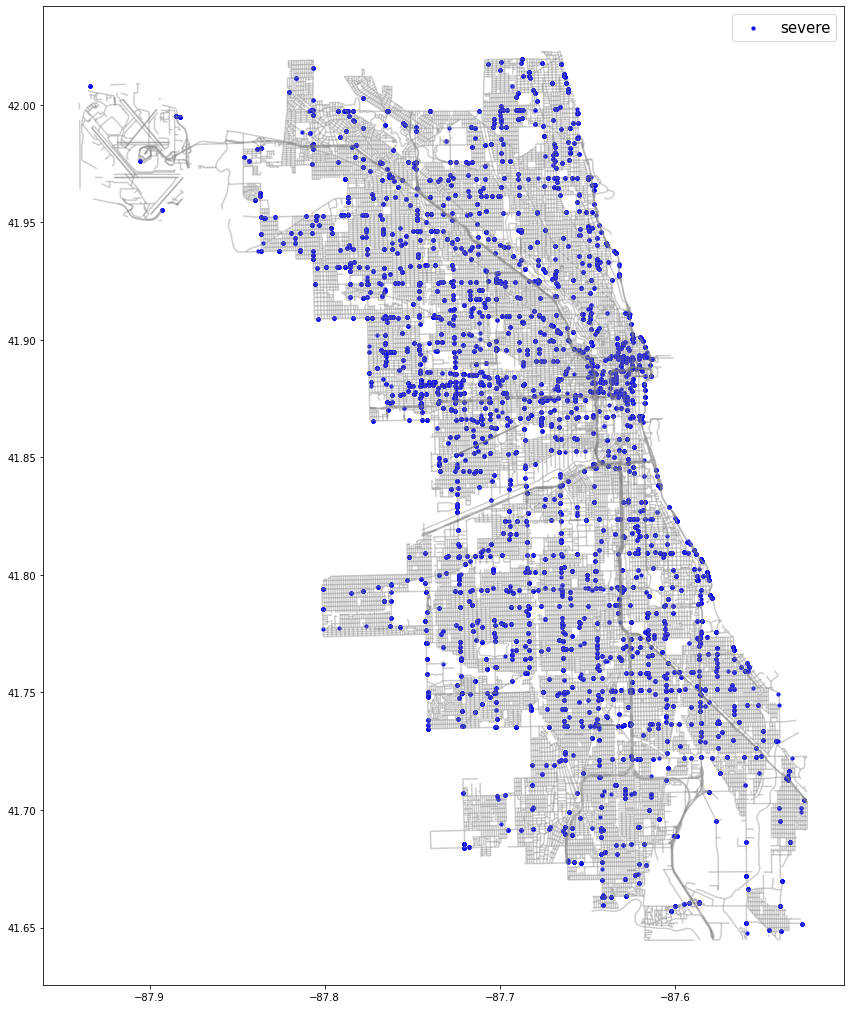

In [82]:
fig, ax = plt.subplots(figsize = (18,18))
street_map.plot(ax = ax, alpha = 0.4, color = 'grey')
geo_df[geo_df['MOST_SEVERE_INJURY'] == 'severe'].plot(ax = ax, 
                                                        markersize = 10, 
                                                        color = 'blue', 
                                                        marker = 'o', 
                                                        label = 'severe')


# geo_df[geo_df['MOST_SEVERE_INJURY'] == 'medium risk'].plot(ax = ax, 
#                                                         markersize = 10, 
#                                                         color = 'red', 
#                                                         marker = 'o', 
#                                                         label = 'medium')

plt.legend(prop = {'size':15})


In [83]:
step  = 0.01
to_bin = lambda x: np.floor(x / step ) * step 
geo_df["latbin"] = geo_df['LATITUDE'].map(to_bin)
geo_df["latbin"]
geo_df["lonbin"] = geo_df['LONGITUDE'].map(to_bin)
geo_df


,CRASH_RECORD_ID,CRASH_DATE,POSTED_SPEED_LIMIT,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,ROADWAY_SURFACE_COND,ROAD_DEFECT,CRASH_TYPE,...,AIRBAG_DEPLOYED,EJECTION,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,MANEUVER,FIRST_CONTACT_POINT,geometry,latbin,lonbin
0,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,2019-07-10,35,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,NOT APPLICABLE,NONE,UNKNOWN,PASSENGER,PERSONAL,BACKING,REAR,POINT (-87.77329 41.91966),41.91,-87.78
1,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,2019-07-10,35,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,NOT APPLICABLE,NONE,UNKNOWN,PASSENGER,PERSONAL,TURNING RIGHT,FRONT,POINT (-87.77329 41.91966),41.91,-87.78
2,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,2019-07-10,35,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,NOT APPLICABLE,NONE,UNKNOWN,PASSENGER,PERSONAL,BACKING,REAR,POINT (-87.77329 41.91966),41.91,-87.78
3,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,2019-07-10,35,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,NOT APPLICABLE,NONE,UNKNOWN,PASSENGER,PERSONAL,TURNING RIGHT,FRONT,POINT (-87.77329 41.91966),41.91,-87.78
4,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,2019-07-10,35,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,NOT APPLICABLE,NONE,UNKNOWN,PASSENGER,PERSONAL,BACKING,REAR,POINT (-87.77329 41.91966),41.91,-87.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2528207,ffff27f5ef6d4465bf2e6da46c1d07ac6f017c6ca1f477...,2019-06-19,25,FUNCTIONING PROPERLY,RAIN,"DARKNESS, LIGHTED ROAD",TURNING,WET,NO DEFECTS,NO INJURY / DRIVE AWAY,...,DEPLOYMENT UNKNOWN,NONE,UNKNOWN,PICKUP,UNKNOWN/NA,TURNING RIGHT,REAR-LEFT,POINT (-87.70523 41.85817),41.85,-87.71
2528208,ffff27f5ef6d4465bf2e6da46c1d07ac6f017c6ca1f477...,2019-06-19,25,FUNCTIONING PROPERLY,RAIN,"DARKNESS, LIGHTED ROAD",TURNING,WET,NO DEFECTS,NO INJURY / DRIVE AWAY,...,DEPLOYMENT UNKNOWN,NONE,UNKNOWN,UNKNOWN/NA,PERSONAL,TURNING LEFT,SIDE-RIGHT,POINT (-87.70523 41.85817),41.85,-87.71
2528209,ffff27f5ef6d4465bf2e6da46c1d07ac6f017c6ca1f477...,2019-06-19,25,FUNCTIONING PROPERLY,RAIN,"DARKNESS, LIGHTED ROAD",TURNING,WET,NO DEFECTS,NO INJURY / DRIVE AWAY,...,DID NOT DEPLOY,NONE,UNKNOWN,PICKUP,UNKNOWN/NA,TURNING RIGHT,REAR-LEFT,POINT (-87.70523 41.85817),41.85,-87.71
2528210,ffff27f5ef6d4465bf2e6da46c1d07ac6f017c6ca1f477...,2019-06-19,25,FUNCTIONING PROPERLY,RAIN,"DARKNESS, LIGHTED ROAD",TURNING,WET,NO DEFECTS,NO INJURY / DRIVE AWAY,...,DID NOT DEPLOY,NONE,UNKNOWN,UNKNOWN/NA,PERSONAL,TURNING LEFT,SIDE-RIGHT,POINT (-87.70523 41.85817),41.85,-87.71


/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
No handles with labels found to put in legend.


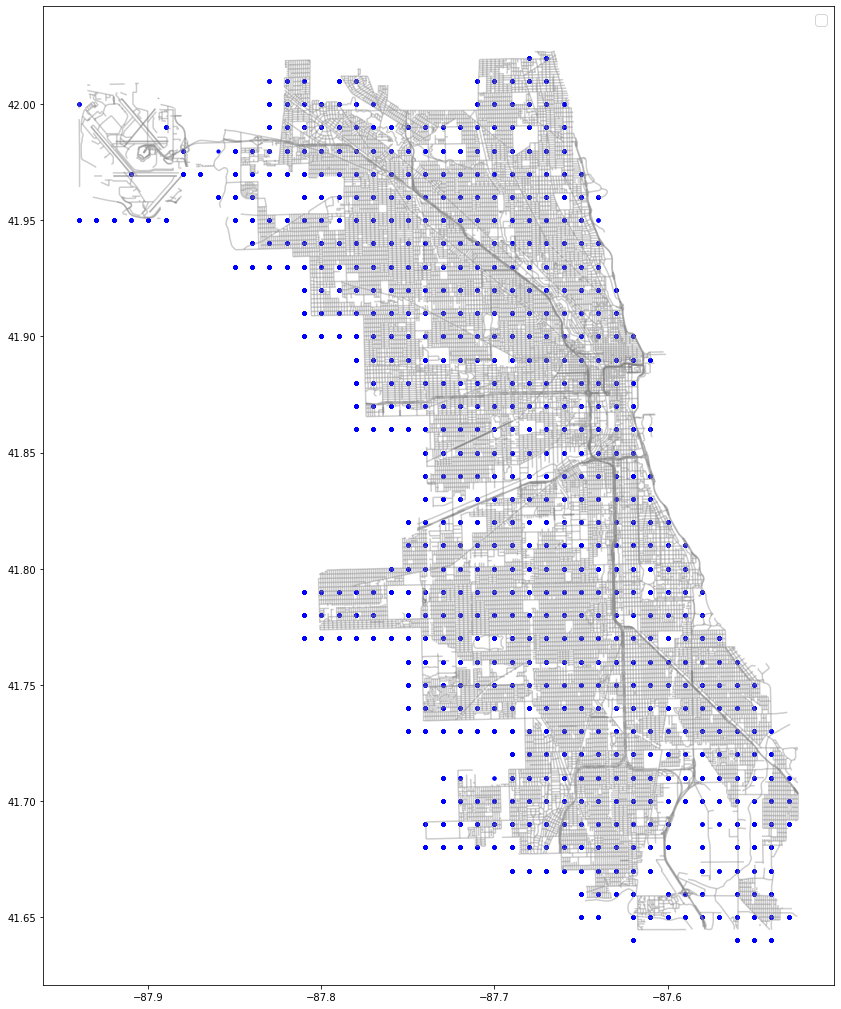

In [87]:
geo_bin = [Point(xy) for xy in zip( geo_df["lonbin"], geo_df["latbin"])]
geo_df_bin = gpd.GeoDataFrame(geo_df, crs=crs,  geometry=geo_bin )

fig, ax = plt.subplots(figsize = (18,18))
street_map.plot(ax = ax, alpha = 0.4, color = 'grey')
geo_df.plot(ax = ax, markersize = 10, color = 'blue', marker = 'o')


plt.legend(prop = {'size':15})




In [88]:
geo_bin = pd.DataFrame(geo_df[["lonbin","latbin"]].value_counts())
geo_bin.reset_index(inplace=True)
geo_bin['accident_count'] = geo_bin[0] 
geo_bin['accident_prob'] = 100*(geo_bin['accident_count']/geo_bin['accident_count'].sum())
print(geo_bin['accident_count'].quantile(.8) )     
print(geo_bin['accident_count'].quantile(.6) )     
print(geo_bin['accident_count'].quantile(.4) )     
print(geo_bin['accident_count'].quantile(.2) )     
      

1229.0
816.0
466.0
167.0


In [89]:
def label_zones(accident_count):
    if accident_count > 1229.0:
        return 5
    if accident_count < 1229.0 and accident_count > 816.0:
        return 4
    if accident_count < 816.0 and accident_count > 466.0:
        return 3
    if accident_count < 466.0 and accident_count > 167.0:
        return 2
    if accident_count < 167.0:
        return 1  

In [90]:
geo_bin['accident_risk'] = geo_bin['accident_count'].map(lambda x: label_zones(x))


In [ ]:
df = geo_df.merge(geo_bin, how = 'left', on = ['lonbin','latbin'])
df.drop(df.columns[np.r_[0,34]], axis=1, inplace=True)
df.info()

In [91]:
discrete_features = df.loc[:,['MOST_SEVERE_INJURY','SAFETY_EQUIPMENT', 'AIRBAG_DEPLOYED', 'EJECTION', 'VEHICLE_DEFECT',
       'VEHICLE_TYPE', 'VEHICLE_USE', 'MANEUVER', 'FIRST_CONTACT_POINT']]


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 543267 entries, 0 to 2528233
Data columns (total 31 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   CRASH_RECORD_ID          543267 non-null  object        
 1   CRASH_DATE               543267 non-null  datetime64[ns]
 2   POSTED_SPEED_LIMIT       543267 non-null  int64         
 3   DEVICE_CONDITION         543267 non-null  object        
 4   WEATHER_CONDITION        543267 non-null  object        
 5   LIGHTING_CONDITION       543267 non-null  object        
 6   FIRST_CRASH_TYPE         543267 non-null  object        
 7   ROADWAY_SURFACE_COND     543267 non-null  object        
 8   ROAD_DEFECT              543267 non-null  object        
 9   CRASH_TYPE               543267 non-null  object        
 10  DAMAGE                   543267 non-null  object        
 11  PRIM_CONTRIBUTORY_CAUSE  543267 non-null  object        
 12  SEC_CONTRIBUTOR

In [93]:
X = df.drop(["MOST_SEVERE_INJURY","CRASH_RECORD_ID"], axis=1)
y = df['MOST_SEVERE_INJURY']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .3, random_state = 42)

In [94]:
X_train

,CRASH_DATE,POSTED_SPEED_LIMIT,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,ROADWAY_SURFACE_COND,ROAD_DEFECT,CRASH_TYPE,DAMAGE,...,SEX,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,MANEUVER,FIRST_CONTACT_POINT,geometry
1287776,2019-05-27,30,NO CONTROLS,RAIN,DAYLIGHT,TURNING,WET,NO DEFECTS,NO INJURY / DRIVE AWAY,"OVER $1,500",...,Unknown,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,NONE,UNKNOWN,VAN/MINI-VAN,UNKNOWN/NA,TURNING RIGHT,UNKNOWN,POINT (-87.61736 41.88755)
1512345,2019-04-09,30,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,TURNING,DRY,NO DEFECTS,INJURY AND / OR TOW DUE TO CRASH,"OVER $1,500",...,M,SAFETY BELT USED,DID NOT DEPLOY,NONE,NONE,PASSENGER,PERSONAL,TURNING LEFT,FRONT-RIGHT,POINT (-87.72343 41.85146)
1450273,2019-12-21,30,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",REAR TO SIDE,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,"OVER $1,500",...,M,USAGE UNKNOWN,DID NOT DEPLOY,NONE,UNKNOWN,PASSENGER,PERSONAL,LEAVING TRAFFIC LANE TO PARK,ROOF,POINT (-87.74529 41.87685)
699247,2019-01-12,30,NO CONTROLS,SNOW,DAYLIGHT,ANGLE,SNOW OR SLUSH,NO DEFECTS,NO INJURY / DRIVE AWAY,"$501 - $1,500",...,F,SAFETY BELT USED,DID NOT DEPLOY,NONE,NONE,SPORT UTILITY VEHICLE (SUV),PERSONAL,STRAIGHT AHEAD,FRONT,POINT (-87.72327 41.92513)
1715553,2019-06-22,30,NO CONTROLS,CLEAR,DAYLIGHT,REAR END,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,"OVER $1,500",...,F,SAFETY BELT USED,DID NOT DEPLOY,NONE,NONE,PASSENGER,PERSONAL,STRAIGHT AHEAD,TOTAL (ALL AREAS),POINT (-87.75724 41.96049)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622198,2019-01-17,30,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",SIDESWIPE SAME DIRECTION,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,"OVER $1,500",...,F,SAFETY BELT USED,DID NOT DEPLOY,NONE,UNKNOWN,PASSENGER,PERSONAL,PASSING/OVERTAKING,SIDE-LEFT,POINT (-87.66101 41.89971)
1276707,2019-01-09,30,UNKNOWN,CLEAR,"DARKNESS, LIGHTED ROAD",REAR END,UNKNOWN,UNKNOWN,NO INJURY / DRIVE AWAY,$500 OR LESS,...,M,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,NONE,UNKNOWN,PICKUP,UNKNOWN/NA,CHANGING LANES,REAR,POINT (-87.62442 41.88843)
1744972,2019-04-21,25,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,SIDESWIPE OPPOSITE DIRECTION,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,"OVER $1,500",...,F,SAFETY BELT USED,DID NOT DEPLOY,NONE,UNKNOWN,SPORT UTILITY VEHICLE (SUV),PERSONAL,STRAIGHT AHEAD,ROOF,POINT (-87.72432 41.96474)
716995,2019-12-31,30,NO CONTROLS,OTHER,DAYLIGHT,PARKED MOTOR VEHICLE,WET,NO DEFECTS,INJURY AND / OR TOW DUE TO CRASH,"OVER $1,500",...,M,CHILD RESTRAINT NOT USED,DID NOT DEPLOY,NONE,NONE,PASSENGER,NOT IN USE,PARKED,UNKNOWN,POINT (-87.64766 41.76504)
